## Imports and setup

In [ ]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
# Which GPU?
!nvidia-smi

Thu Oct  1 14:27:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

--2020-10-01 14:27:40--  https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6064 (5.9K) [text/plain]
Saving to: ‘resnet_cifar10.py’

resnet_cifar10.py   100%[===================>]   5.92K  --.-KB/s    in 0s      

2020-10-01 14:27:40 (37.4 MB/s) - ‘resnet_cifar10.py’ saved [6064/6064]



In [ ]:
!pip install -q wandb

     |████████████████████████████████| 1.7MB 5.1MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 122kB 32.6MB/s 
     |████████████████████████████████| 163kB 31.3MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 


In [ ]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import resnet_cifar10
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

# Authorize wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# ResNetCIFAR10
n = 4
depth =  n * 9 + 2
n_blocks = ((depth - 2) // 9) - 1

# The input tensor
inputs = Input(shape=(32, 32, 3))

# The Stem Convolution Group
x = resnet_cifar10.stem(inputs)
   
# The learner
outputs = resnet_cifar10.learner(x, n_blocks)

# Instantiate the Model
resnet_headless_model = Model(inputs, outputs)

In [ ]:
resnet_headless_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 32, 32, 16)   64          conv2d_166[0][0]                 
__________________________________________________________________________________________________
re_lu_164 (ReLU)                (None, 32, 32, 16)   0           batch_normalization_164[0][0]    
_______________________________________________________________________________________

## The data

In [ ]:
# Load the training set of CIFAR10
(X_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
X_train = X_train/255.
X_train.shape

170500096/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3)

In [ ]:
! wget -q https://github.com/ariG23498/G-SimCLR/releases/download/v2.0/CIFAR10.zip
! unzip -q CIFAR10.zip

In [ ]:
auto_model = tf.keras.models.load_model('autoencoder_cifar10.h5')

In [ ]:
auto_model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        

In [ ]:
layer_name = 'retrieval'
slice_model = tf.keras.Model(
    inputs=auto_model.input,
    outputs=auto_model.get_layer(layer_name).output
    )
slice_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)       

In [ ]:
latent_train = slice_model.predict(X_train)
embedding_train = tf.keras.layers.GlobalAveragePooling2D()(latent_train)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
BATCH_SIZE = 64
classifier = KMeans(n_clusters=BATCH_SIZE, random_state=0).fit(embedding_train)
# labels of the clusters
labels = classifier.labels_
labels.shape

(50000,)

In [ ]:
import pandas as pd

In [ ]:
# Building the DataFrame
df = pd.DataFrame()
df['cluster_labels'] = labels
df['imag_ind'] = np.arange(0,len(df))
df = df[['imag_ind','cluster_labels']]
df.head()

,imag_ind,cluster_labels
0,0,39
1,1,57
2,2,61
3,3,1
4,4,41


In [ ]:
# The rank according to the cluster_labels
df["rank"] = df.groupby("cluster_labels")["imag_ind"].rank("dense", ascending=True)
df.head()

,imag_ind,cluster_labels,rank
0,0,39,1.0
1,1,57,1.0
2,2,61,1.0
3,3,1,1.0
4,4,41,1.0


In [ ]:
# Sorting the labels by cluster_labels and rank
df_data = df.sort_values(by = ['cluster_labels','rank'])
df_data.head()

,imag_ind,cluster_labels,rank
7,7,0,1.0
52,52,0,2.0
113,113,0,3.0
143,143,0,4.0
282,282,0,5.0


In [ ]:
# Sort with respect to rank only
df_data2 = df_data.sort_values(by = ['rank'])
df_data2.head()

,imag_ind,cluster_labels,rank
7,7,0,1.0
82,82,47,1.0
57,57,48,1.0
92,92,49,1.0
20,20,13,1.0


In [ ]:
arr_ind = df_data2['imag_ind'].values
X_train = X_train[arr_ind]
X_train.shape

(50000, 32, 32, 3)

## Continuation with SimCLR

In [ ]:
class CustomAugment(object):
    def __call__(self, sample):
        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # randomly apply transformation (color distortions and blur) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.5)
        sample = self._random_apply(self._color_drop, sample, p=0.5)

        return sample

    def _color_jitter(self, x, s=0.2):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        image = tf.image.rgb_to_grayscale(x)
        image = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [ ]:
data_augmentation = Sequential([Lambda(CustomAugment())])

In [ ]:
BATCH_SIZE = 64

# # Create TensorFlow dataset
# def normalize(image):
#     return tf.image.convert_image_dtype(image, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((X_train))
train_ds = (
    train_ds
    # .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # .cache()
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2020-10-01 14:31:21--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]     891  --.-KB/s    in 0s      

2020-10-01 14:31:22 (35.0 MB/s) - ‘helpers.py’ saved [891/891]

--2020-10-01 14:31:22--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘losses.py’

los

Don't forget to comment the augmentation import in the `helpers.py` script.

In [ ]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [ ]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [ ]:
# Architecture utils
def get_resnet_simclr_deeper(hidden_1, hidden_2, hidden_3):
    inputs = Input((32, 32, 3))
    h = resnet_headless_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)
    
    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [ ]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [ ]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        wandb.log({"nt_xentloss": np.mean(step_wise_loss)})
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


  0%|          | 0/15 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  7%|▋         | 1/15 [02:54<40:36, 174.01s/it]

epoch: 1 loss: 0.258


 73%|███████▎  | 11/15 [30:36<11:06, 166.50s/it]

epoch: 11 loss: 0.057


100%|██████████| 15/15 [41:41<00:00, 166.75s/it]


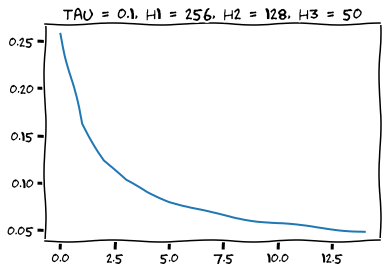

In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
    reduction=tf.keras.losses.Reduction.SUM)

# Initialize wandb
wandb.init(entity="g-simclr", project="g-simclr", id="cifar10-gsimclr")

# Train SimCLR with SGD with CosineDecay restarts
first_decay_steps = 1000
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate=0.1,
      first_decay_steps=first_decay_steps))

optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)
resnet_simclr_2 = get_resnet_simclr_deeper(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, 
    optimizer, criterion,
    temperature=0.1, epochs=15)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()